In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_absolute_error
import time
import json
from lib.llm_utils import *

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = 'llm_v1_tokens_v2_lite'
DATA_FNAME = 'data/llm/events_test.txt'
K = 1

# Organizing data

In [3]:
df = pd.read_csv(DATA_FNAME, sep=' ', header=None, dtype=str)
df = df.fillna('<NaN>')

# Load Model

In [4]:
tokenizer_map, detokenizer_map = get_tokenizer_map(df)
restrictions, offset_restrictions = get_restrictions(K)

In [5]:
model = torch.load(f'models/llm/full_{MODEL_NAME}.pth')
model.eval()

MultiLayerBinaryClassifier(
  (model): Sequential(
    (0): Linear(in_features=18, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=139, bias=True)
    (5): Sigmoid()
  )
)

# Metrics

In [6]:
def calculate_error(df, loc, k=1, metrics_type='regression'):
    restrictions, offset_restrictions = get_restrictions(k)

    _df = df.copy()
    _df['target'] = _df[loc]
    for j in range(loc, k*11+7):
        _df[j] = '<NaN>'
    _df = _df[(_df['target'] != '<NaN>') & (_df['target'] != '<GAME_OVER>')]

    df_train_11 = _df.copy()

    for j in range(0, k*11+7):
        _df[j] = _df[j].map(tokenizer_map)

    X_train_11 = _df.drop('target', axis=1).astype(float).values

    pred_11 = model(torch.tensor(X_train_11, dtype=torch.float32).to(DEVICE))
    pred_11 = torch.argmax(pred_11[:, restrictions[loc]], dim=1) + offset_restrictions[loc]
    df_train_11['pred'] = pred_11.cpu().detach().numpy()
    df_train_11['target'] = df_train_11['target'].map(tokenizer_map)
    
    if metrics_type == 'regression':
        return {'MAE': round(mean_absolute_error(df_train_11['target'], df_train_11['pred']), 5), 'R2': round(r2_score(df_train_11['target'], df_train_11['pred']), 5)}
    elif metrics_type == 'classification':
        if len(restrictions[loc]) == 2:
            return {'ACC': round(accuracy_score(df_train_11['target'], df_train_11['pred']), 5), 'F1': round(f1_score(df_train_11['target'], df_train_11['pred']), 5)}
        else:
            return {'ACC': round(accuracy_score(df_train_11['target'], df_train_11['pred']), 5), 'F1': round(f1_score(df_train_11['target'], df_train_11['pred'], average='weighted'), 5)}
    else:
        raise Exception('Unknown metrics type')

In [7]:
pd.DataFrame({
    'Event Type': calculate_error(df, 11, k=K, metrics_type='classification'),
    'Is Goal': calculate_error(df, 12, k=K, metrics_type='classification'),
    'Is Accurate': calculate_error(df, 13, k=K, metrics_type='classification'),
    'Is Home Team': calculate_error(df, 14, k=K, metrics_type='classification'),
    'Time Elapsed': calculate_error(df, 15, k=K, metrics_type='regression'),
    'x': calculate_error(df, 16, k=K, metrics_type='regression'),
    'y': calculate_error(df, 17, k=K, metrics_type='regression'),
})

,Event Type,Is Goal,Is Accurate,Is Home Team,Time Elapsed,x,y
ACC,0.57294,0.99842,0.82469,0.91534,NaN,NaN,NaN
F1,0.51770,0.67636,0.87030,0.91505,NaN,NaN,NaN
MAE,NaN,NaN,NaN,NaN,1.74213,7.35026,12.81247
R2,NaN,NaN,NaN,NaN,0.39220,0.77132,0.50249


# xG Map

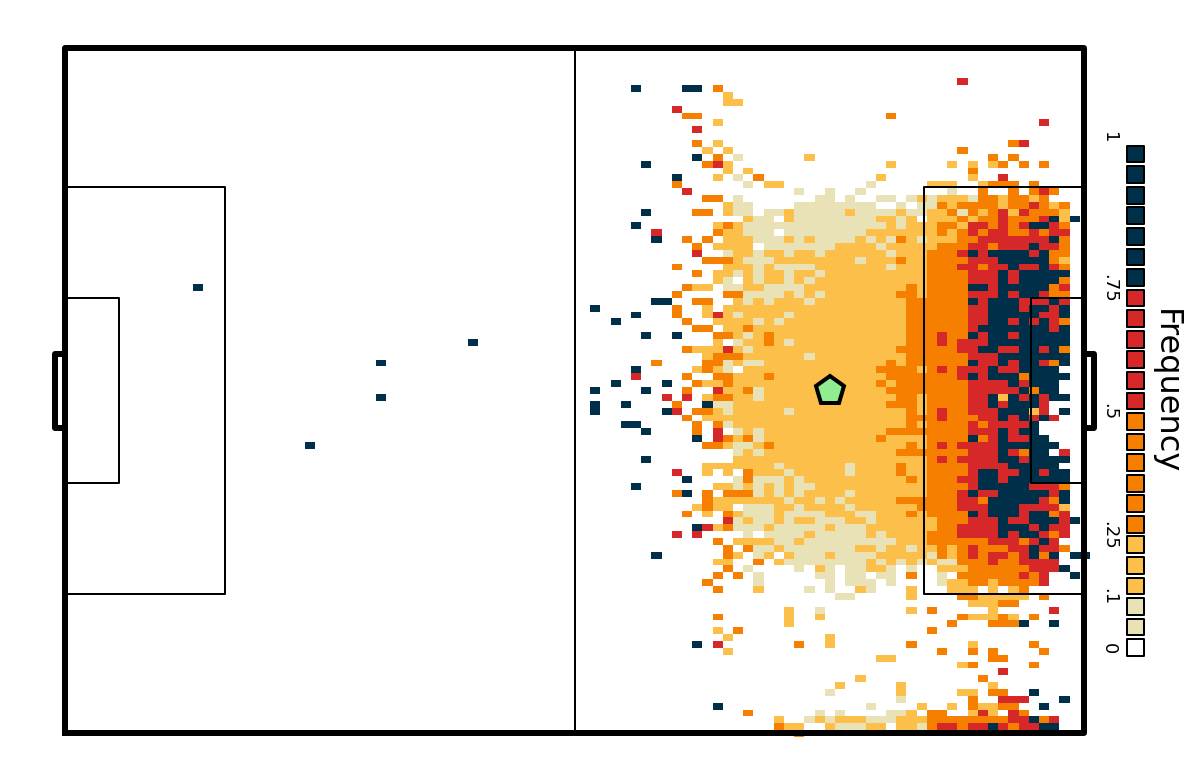

In [8]:
base_state = ['simple_pass', '0', '1', '1', '1', '20', '47', '75', '50', '0', '0']
draw_xg_map(base_state, model=model, k=K)
plt.plot(75, 50, marker='p', color='lightgreen', markersize=15, markeredgecolor='black', markeredgewidth=2)
plt.savefig(f'figures/paper_sigkdd/{MODEL_NAME}_xg_v1.pdf', bbox_inches='tight')

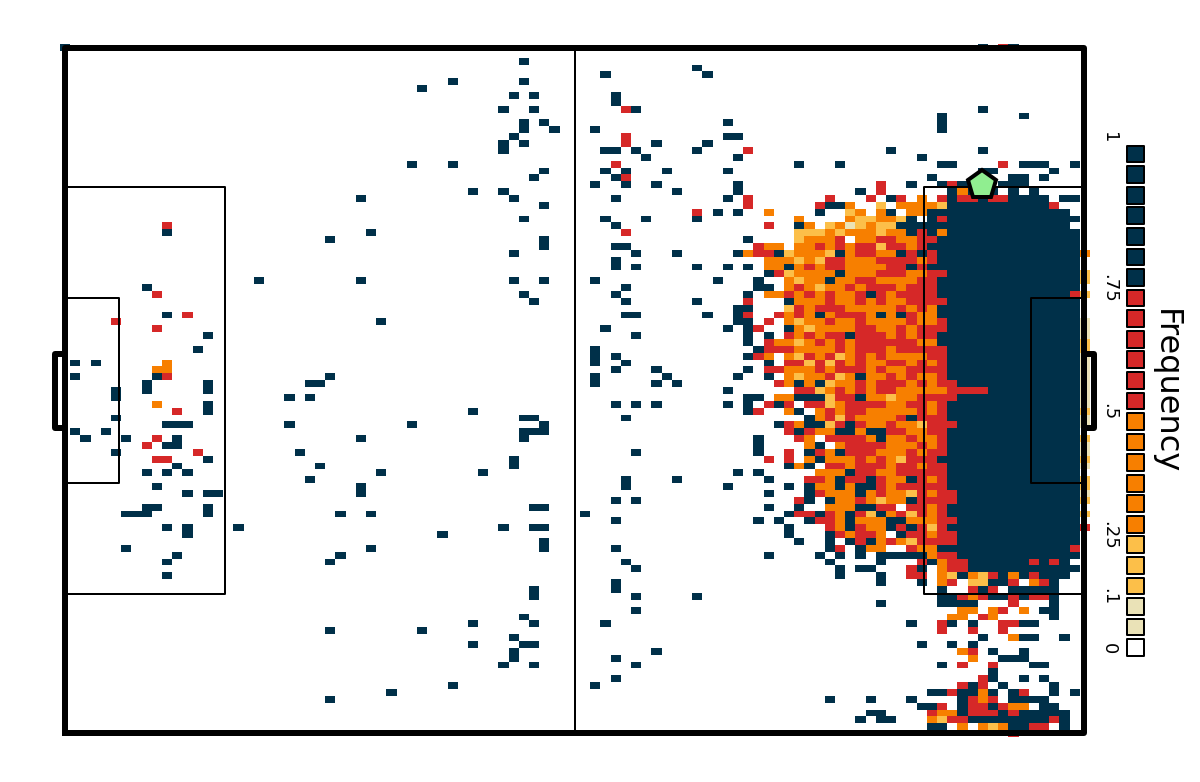

In [9]:
base_state = ['cross', '0', '1', '1', '1', '20', '40', '90', '80', '0', '0']
draw_xg_map(base_state, model=model, k=K)
plt.plot(90, 80, marker='p', color='lightgreen', markersize=15, markeredgecolor='black', markeredgewidth=2)
plt.savefig(f'figures/paper_sigkdd/{MODEL_NAME}_xg_v2.pdf', bbox_inches='tight')

# Short-term Scoring Probability

## Original

In [10]:
forecast_df = df.loc[912059:912068].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
forecast_df[[i for i in range(11)]].head(3)

,0,1,2,3,4,5,6,7,8,9,10
912059,120,0,1,0,2,46,58,100,0,0,2
912060,101,0,1,0,2,47,0,90,10,0,2
912061,101,0,1,0,2,47,4,75,22,0,2


In [11]:
df_original = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=2000, n_sims_per_row=1000)
df_original = pd.concat([df_original[df_original.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)
df_original.head(3)

912059  912060  912061  912062  912063  912064  912065  912066  \
9   10                                                                    
0.0 2.0   870.0   887.0   892.0   883.0   896.0   875.0   886.0   671.0   
    3.0    69.0    72.0    57.0    67.0    63.0    69.0    78.0   265.0   
1.0 2.0    49.0    37.0    44.0    42.0    38.0    51.0    30.0    35.0   

         912067  912068  
9   10                   
0.0 2.0     0.0     0.0  
    3.0   930.0   938.0  
1.0 2.0     0.0     0.0

## Artificial 0-0 Score

In [12]:
forecast_df = df.loc[912059:912068].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
forecast_df.loc[forecast_df[10] == 2, 10] = 0
forecast_df.loc[forecast_df[10] == 3, 10] = 1
forecast_df[[i for i in range(11)]].head(3)

,0,1,2,3,4,5,6,7,8,9,10
912059,120,0,1,0,2,46,58,100,0,0,0
912060,101,0,1,0,2,47,0,90,10,0,0
912061,101,0,1,0,2,47,4,75,22,0,0


In [13]:
df_artificial_score = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=2000, n_sims_per_row=1000)
df_artificial_score = pd.concat([df_artificial_score[df_artificial_score.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)
df_artificial_score.head(3)

912059  912060  912061  912062  912063  912064  912065  912066  \
9   10                                                                    
0.0 0.0   875.0   890.0   888.0   879.0   890.0   872.0   883.0   708.0   
    1.0    67.0    70.0    65.0    70.0    65.0    77.0    69.0   237.0   
1.0 0.0    46.0    36.0    40.0    45.0    44.0    45.0    41.0    32.0   

         912067  912068  
9   10                   
0.0 0.0     0.0     0.0  
    1.0   927.0   933.0  
1.0 0.0     0.0     0.0

## Artificial Time remaining

In [14]:
forecast_df = df.loc[912059:912068].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
forecast_df[[5]] = 0
forecast_df[[i for i in range(11)]].head(3)

,0,1,2,3,4,5,6,7,8,9,10
912059,120,0,1,0,2,0,58,100,0,0,2
912060,101,0,1,0,2,0,0,90,10,0,2
912061,101,0,1,0,2,0,4,75,22,0,2


In [15]:
%%time
df_artificial_time = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=2000, n_sims_per_row=1000)
df_artificial_time = pd.concat([df_artificial_time[df_artificial_time.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)
df_artificial_time.head(3)

CPU times: total: 10.7 s
Wall time: 9.95 s


912059  912060  912061  912062  912063  912064  912065  912066  \
9   10                                                                    
2.0 3.0   123.0   108.0   103.0   120.0   116.0   116.0   100.0    90.0   
1.0 3.0   107.0   111.0   108.0   110.0   116.0   128.0   115.0   116.0   
    4.0    89.0    77.0    88.0    87.0    89.0    78.0    77.0   102.0   

         912067  912068  
9   10                   
2.0 3.0    71.0    80.0  
1.0 3.0    56.0    81.0  
    4.0   117.0   121.0

# Artificial Score and Time

In [16]:
forecast_df = df.loc[912059:912068].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
forecast_df[[5]] = 0
forecast_df.loc[forecast_df[10] == 2, 10] = 0
forecast_df.loc[forecast_df[10] == 3, 10] = 1
forecast_df[[i for i in range(11)]].head(3)

,0,1,2,3,4,5,6,7,8,9,10
912059,120,0,1,0,2,0,58,100,0,0,0
912060,101,0,1,0,2,0,0,90,10,0,0
912061,101,0,1,0,2,0,4,75,22,0,0


In [17]:
df_artificial_score_time = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=2000, n_sims_per_row=1000)
df_artificial_score_time = pd.concat([df_artificial_score_time[df_artificial_score_time.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)
df_artificial_score_time.head(3)

912059  912060  912061  912062  912063  912064  912065  912066  \
9   10                                                                    
1.0 1.0   113.0   135.0   113.0   116.0   128.0   111.0   108.0   103.0   
2.0 1.0   102.0    95.0   106.0    92.0   114.0    96.0    97.0   105.0   
    0.0    86.0    67.0    78.0    76.0    71.0    64.0    64.0    49.0   

         912067  912068  
9   10                   
1.0 1.0    92.0    96.0  
2.0 1.0    74.0    64.0  
    0.0     0.0     0.0

# Analysis

## Realistic performance on the number of goals scored per match.

In [18]:
_df = df_artificial_score_time.copy()
_df['goals'] = _df.index.map(lambda x: x[0] + x[1])
_df['new_goals'] = _df.index.map(lambda x: x[0] + x[1])
for col in _df.columns[:-2]:
    _df[col] = _df[col] * _df['new_goals'] / _df[col].sum()
_df[_df.columns[:-2]].sum()

912059    2.904
912060    2.956
912061    3.049
912062    3.035
912063    2.932
912064    3.022
912065    2.935
912066    3.107
912067    3.988
912068    3.894
dtype: float64

## Probabilities within scenarios

In [19]:
def calculate_probability_away_win(df):
    _df = df.copy()
    _df['wins'] = _df.index.map(lambda x: x[0] < x[1])
    _df['draws'] = _df.index.map(lambda x: x[0] == x[1])

    points = []
    for col in _df.columns[:-2]:
        points.append(((_df[col] * _df['wins']).sum() * 3 + (_df[col] * _df['draws']).sum()) / _df[col].sum())
    
    return points

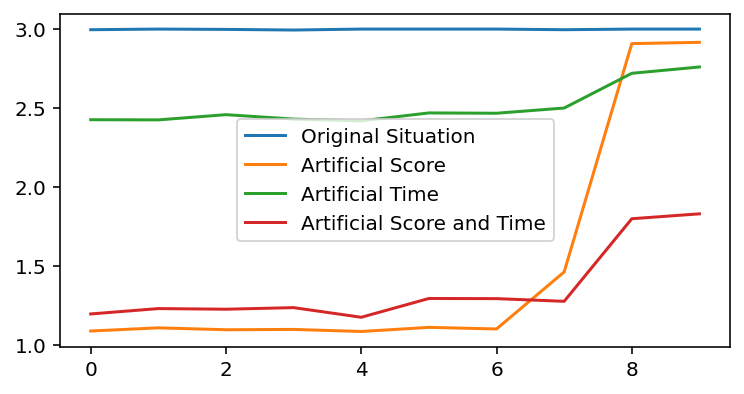

In [20]:
plt.rcParams['figure.figsize'] = (6, 3)
plt.plot(calculate_probability_away_win(df_original), label='Original Situation')
plt.plot(calculate_probability_away_win(df_artificial_score), label='Artificial Score')
plt.plot(calculate_probability_away_win(df_artificial_time), label='Artificial Time')
plt.plot(calculate_probability_away_win(df_artificial_score_time), label='Artificial Score and Time')
plt.legend();

## Simulating full game

In [21]:
forecast_df = df.loc[910375:912068].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
forecast_df[[i for i in range(11)]].head(3)

,0,1,2,3,4,5,6,7,8,9,10
910375,101,0,1,0,1,0,5,49,50,0,0
910376,101,0,1,0,1,0,6,38,57,0,0
910377,101,0,1,0,1,0,9,28,35,0,0


In [22]:
%%time
df_full = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=2000, n_sims_per_row=100)
df_full = pd.concat([df_full[df_full.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)
df_full.head(3)

CPU times: total: 1min 24s
Wall time: 1min 25s


,,910375,910376,910377,910378,910379,910380,910381,910382,910383,910384,...,912059,912060,912061,912062,912063,912064,912065,912066,912067,912068
9,10,,,,,,,,,,,,,,,,,,,,,
2.0,3.0,8.0,5.0,4.0,3.0,9.0,5.0,5.0,5.0,6.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,2.0,7.0,8.0,4.0,5.0,8.0,4.0,9.0,3.0,6.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,2.0,7.0,8.0,10.0,6.0,5.0,2.0,3.0,9.0,7.0,11.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## What if analysis - betting scenario

In [23]:
forecast_df = df.loc[910375:912067].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
forecast_df = forecast_df[(forecast_df[4] == 2)]
forecast_df[[i for i in range(11)]].head(3)

,0,1,2,3,4,5,6,7,8,9,10
911239,101,0,1,1,2,0,1,51,48,0,0
911240,101,0,1,1,2,0,3,45,50,0,0
911241,101,0,1,1,2,0,6,30,31,0,0


In [24]:
df_wia = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=2000, n_sims_per_row=100)
df_wia = pd.concat([df_wia[df_wia.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)
df_wia.head(3)

911239  911240  911241  911242  911243  911244  911245  911246  \
9   10                                                                    
2.0 1.0    12.0    12.0     9.0     6.0     8.0    12.0    10.0    15.0   
    0.0     9.0     6.0     5.0     4.0     9.0    11.0     6.0     6.0   
3.0 1.0     8.0     5.0     5.0     6.0     3.0     5.0     5.0     9.0   

         911247  911248  ...  912058  912059  912060  912061  912062  912063  \
9   10                   ...                                                   
2.0 1.0    15.0    12.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
    0.0     9.0     5.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3.0 1.0     6.0     7.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

         912064  912065  912066  912067  
9   10                                   
2.0 1.0     0.0     0.0     0.0     0.0  
    0.0     0.0     0.0     0.0     0.0  
3.0 1.0     0.0     0.0     0.0     0.0  

[3 rows x 829 columns]

In [25]:
def calculate_event_to_end_probabilities(df):
    _df = df.copy()
    _df['h_wins'] = _df.index.map(lambda x: x[0] > x[1])
    _df['draws'] = _df.index.map(lambda x: x[0] == x[1])
    _df['a_wins'] = _df.index.map(lambda x: x[0] < x[1])
    _df['over_2_5'] = _df.index.map(lambda x: (x[0] + x[1]) > 2.5)
    _df['under_2_5'] = _df.index.map(lambda x: (x[0] + x[1]) <= 2.5)

    h_wins = []
    draws = []
    a_wins = []
    over_2_5 = []
    under_2_5 = []
    for col in _df.columns[:-2]:
        h_wins.append((_df[col] * _df['h_wins']).sum() / _df[col].sum())
        draws.append((_df[col] * _df['draws']).sum() / _df[col].sum())
        a_wins.append((_df[col] * _df['a_wins']).sum() / _df[col].sum())
        over_2_5.append((_df[col] * _df['over_2_5']).sum() / _df[col].sum())
        under_2_5.append((_df[col] * _df['under_2_5']).sum() / _df[col].sum())
    
    return h_wins, draws, a_wins, over_2_5, under_2_5

CPU times: total: 406 ms
Wall time: 401 ms


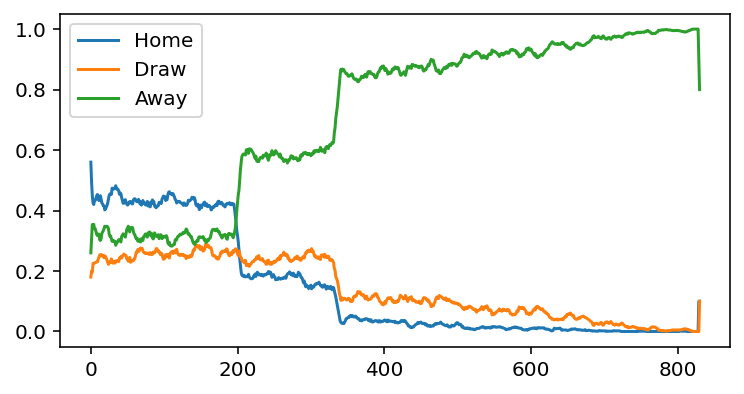

In [26]:
%%time
plt.rcParams['figure.figsize'] = (6, 3)
h_wins, draws, a_wins, _, _ = calculate_event_to_end_probabilities(df_wia)
plt.plot(pd.Series(h_wins).rolling(10, min_periods=1).mean()[:-1], label='Home')
plt.plot(pd.Series(draws).rolling(10, min_periods=1).mean()[:-1], label='Draw')
plt.plot(pd.Series(a_wins).rolling(10, min_periods=1).mean()[:-1], label='Away')
plt.legend();

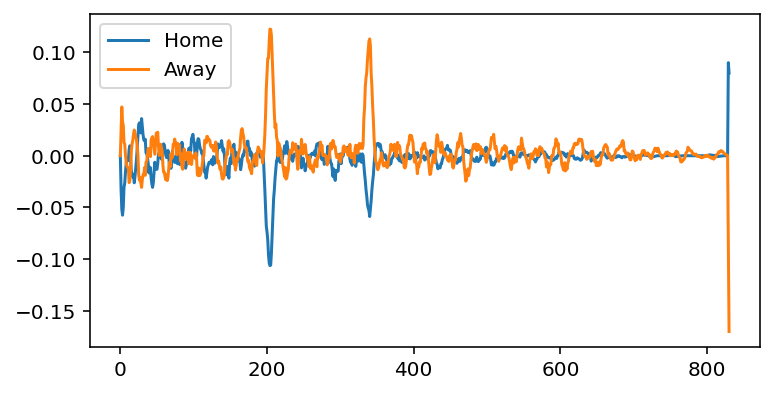

In [27]:
plt.rcParams['figure.figsize'] = (6, 3)
h_wins, draws, a_wins, _, _ = calculate_event_to_end_probabilities(df_wia)
plt.plot(pd.Series(h_wins).rolling(10, min_periods=1).mean()[:-1] - pd.Series(h_wins).rolling(10, min_periods=1).mean().rolling(10, min_periods=1).mean()[:-1], label='Home')
#plt.plot(pd.Series(draws).rolling(10, min_periods=1).mean()[:-1] - pd.Series(draws).rolling(10, min_periods=1).mean().rolling(10, min_periods=1).mean()[:-1], label='Draw')
plt.plot(pd.Series(a_wins).rolling(10, min_periods=1).mean()[:-1] - pd.Series(a_wins).rolling(10, min_periods=1).mean().rolling(10, min_periods=1).mean()[:-1], label='Away')
plt.legend();

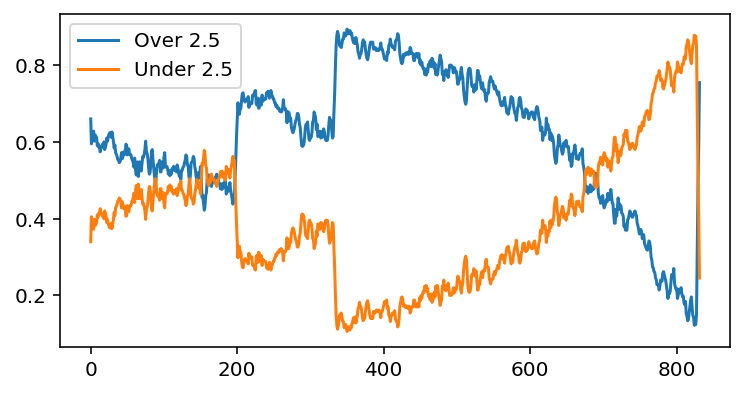

In [28]:
plt.rcParams['figure.figsize'] = (6, 3)
_, _, _, over, under = calculate_event_to_end_probabilities(df_wia)
plt.plot(pd.Series(over).rolling(5, min_periods=1).mean(), label='Over 2.5')
plt.plot(pd.Series(under).rolling(5, min_periods=1).mean(), label='Under 2.5')
plt.legend();

## Short term scoring chance

In [29]:
forecast_df = df.loc[910375:912067].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
forecast_df = forecast_df[(forecast_df[4] == 2)]
forecast_df[[i for i in range(11)]].head(3)

,0,1,2,3,4,5,6,7,8,9,10
911239,101,0,1,1,2,0,1,51,48,0,0
911240,101,0,1,1,2,0,3,45,50,0,0
911241,101,0,1,1,2,0,6,30,31,0,0


In [30]:
N_SIMS = 1000

In [31]:
df_la10 = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=10, n_sims_per_row=N_SIMS)
df_la10 = pd.concat([df_la10[df_la10.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)
df_la10.head(3)

,,911239,911240,911241,911242,911243,911244,911245,911246,911247,911248,...,912058,912059,912060,912061,912062,912063,912064,912065,912066,912067
9,10,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,975.0,975.0,977.0,980.0,972.0,978.0,984.0,972.0,974.0,969.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.0,16.0,14.0,12.0,14.0,10.0,13.0,11.0,23.0,9.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,1.0,9.0,10.0,11.0,6.0,18.0,9.0,5.0,5.0,17.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
momentum_h_scoring = []
momentum_a_scoring = []
for i in forecast_df.index:
    current_h_score = forecast_df.loc[i][9]
    current_a_score = forecast_df.loc[i][10]

    momentum_h_scoring.append(df_la10[i].loc[current_h_score+1, current_a_score])
    momentum_a_scoring.append(df_la10[i].loc[current_h_score, current_a_score+1])
    #print(i, current_h_score, current_a_score, df_la10[i].loc[current_h_score, current_a_score], , df_la10[i].loc[current_h_score, current_a_score+1])

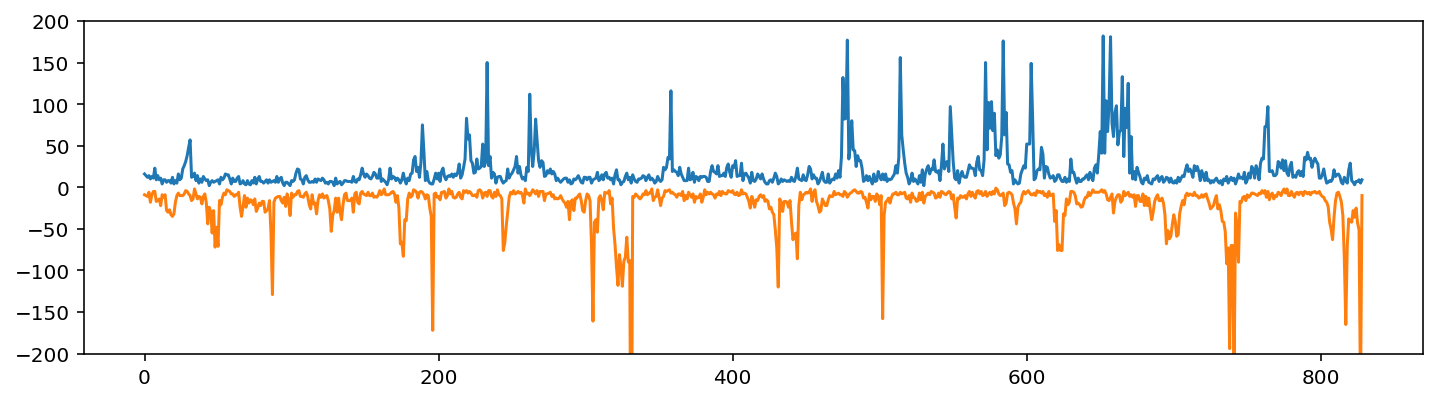

In [33]:
plt.rcParams['figure.figsize'] = (12, 3)
plt.plot(np.array(momentum_h_scoring))
plt.plot(-np.array(momentum_a_scoring))
plt.ylim([-200, 200]);